In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## data loading

In [2]:
data_path = "./data/TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [3]:
data_info

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0
...,...,...,...,...,...,...,...,...
4575,WPAC,201733W,105.0,8.4,2017122600,20.0,0.0,1007.0
4576,WPAC,201733W,104.7,8.4,2017122603,20.0,0.0,1007.0
4577,WPAC,201733W,104.4,8.4,2017122606,20.0,0.0,1007.0
4578,WPAC,201733W,104.0,8.4,2017122609,18.0,0.0,1009.0


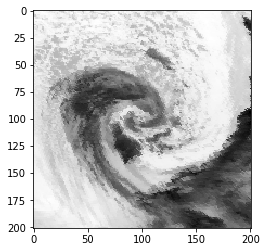

In [6]:
img = data_matrix[4,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

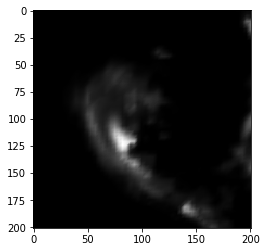

In [7]:
img = data_matrix[4,:,:,3].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

## Data preprocessing

In [3]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [4]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [40]:
X_tensor = tf.convert_to_tensor(X_irpmw)
y = tf.convert_to_tensor(y)

### Standardization

In [28]:
X_std = tf.image.per_image_standardization(X_tensor)

In [29]:
img = X_std[0,:,:,:]
print(np.mean(img), np.std(img))

-2.1339115e-08 1.0000001


## Preprocessing layers

In [9]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

In [30]:
pp = Preprocessing()

In [31]:
rotated = pp(X_std[:5,:,:,:], training=True)

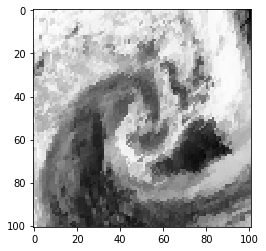

In [32]:
fig, ax = plt.subplots()
pos = ax.imshow(rotated[4,:,:,0], plt.cm.gray)

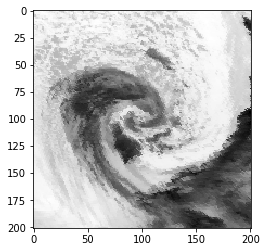

In [33]:
fig, ax = plt.subplots()
pos = ax.imshow(X_std[4,:,:,0], plt.cm.gray)

## Building a model

In [34]:
reg_param = 1e-5
model = keras.models.Sequential([
    Preprocessing(),
    keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_param)),
    keras.layers.Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_param)),
])

In [35]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999))

In [ ]:
history = model.fit(X_std, y)

Train on 4580 samples
